# Multiprocessing between nodes using MPI

MOTIVATION

* ?

LEARNING OUTCOMES

* ?

## Introduction

DISTRIBUTING WORK OVER CORES OF ONE MACHINE USING MULTIPROCESSING/MULTITHREADING ONLY SCALES SO FAR

WHAT IF HAVE A PROBLEM THAT COULD EFFICIENTLY SCALE TO MORE CPUS THAN HAVE IN A SINGLE MACHINE?

wHAT IF HAVE A PROBLEM WHERE NEED MORE MEMORY PER CORE THAN HAVE IN A SINGLE MACHINE?

WANT TO LOOK AT DISTRIBUTING WORK *BETWEEN* MACHINES

FOR YEARS DE-FACTO STANDARD FOR THIS IN RESEARCH COMPUTING ENVIRONMENTS HAS BEEN MPI

-> MESSAGE PASSING INTERFACE

START A SINGLE PROGRAM MULTIPLE TIMES TO GIVE N PROCESSES.  MAY BE ON SINGLE MACHINE OR DISTRIBUTED BETWEEN MACHINES.

THAT SINGLE PROGRAM INCLUDES LOGIC EXECUTED BY ALL PROGRAMS BUT SPECIFY LOGIC FOR SUBSETS OF PROCESSES OR SINGLE PROCESSES USING CONDITIONALS E.G. in pseudocode:

```python
# Get the 'rank' (MPI process ID) of _this_ process
rank = get_mpi_rank()

# Done for all ranks 
print("Hello from rank {}".format(rank))

# Do different things based on rank 
if rank == 0:
    print("I am the boss (rank = {})".format(rank))
else:
    print("I am a lowly worker (rank = {})".format(rank))
```

THESE PROCESSES CAN PASS MESSAGES (DATA AND CONTROL) INFORMATION BETWEEN EACH OTHER.

---

## Parallelising the calculation of the Mandelbrot set using MPI

Let's look at a problem that can be parallelised using MPI. 

The [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) is a set of numbers on a [complex](https://en.wikipedia.org/wiki/Complex_number) plane.  
Each pixel is calculated independently using a function that takes its coordinates in that plane (a complex number) 
and transforms it into an integer by an iterative method. 
The number of iterations required vary with the input to the function.
If you treat the integer output as the pixel color for a 2D bitmap you get:  

<img src="static/mandelbrot-example.png" alt="Mandelbrot set visualised" />

SERIAL CODE:
(EXAMPLE BASED ON BOOK)

In [52]:
def cal_pixel(c):
    max_ = 256
    z = complex(0, 0)
    count = 0  # number of iterations
    
    while True:
        temp = (z.real ** 2) - (z.imag ** 2) + c.real
        z_imag = 2 * z.real * z.imag + c.imag
        z = complex(temp, z_imag)
        
        length_sq = (z.real ** 2) + (z.imag ** 2) 
        count += 1
        if (length_sq >= 4.0 or count >= max_):
            break
    return count

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from math import floor
%matplotlib inline

In [137]:
long_edge = 1000
img = np.zeros((long_edge, long_edge), dtype=np.float)

min_ = complex(-1.6, -1.5)
scale = complex(2.2, 3.) / long_edge

In [138]:
for i in range(long_edge):
    for j in range(long_edge):
        c_real = min_.real + (i * scale.real)
        c_imag = min_.imag + (j * scale.imag)
        img[i, j] = cal_pixel(complex(c_real, c_imag))

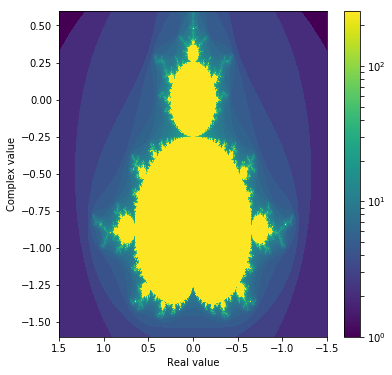

In [158]:
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.imshow(img, 
          extent=[min_.imag + scale.imag * long_edge, 
                  min_.imag,
                  min_.real, 
                  min_.real + scale.real * long_edge],
          aspect='auto',
          norm=LogNorm())
ax.set_xlabel('Real value')
ax.set_ylabel('Complex value')
fig.colorbar(cax);